In [57]:
#!pip install transformers
#!pip install torch          # For PyTorch
#!pip install tensorflow     # For TensorFlow
#!pip install numpy
#!pip install pandas



In [58]:
import transformers
import torch
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns


In [ ]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('wietsedv/bert-base-dutch-cased')
model = BertModel.from_pretrained('wietsedv/bert-base-dutch-cased')


In [60]:
import pandas as pd

simlex = pd.read_csv('SimLex-999-Dutch-final.txt', sep='\t')


### Code for getting layer-wise similarity, all layers, including subtokenized words:

In [61]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

def get_word_embedding(word, layer_nums):
    # Tokenize the word into subtokens and add special tokens [CLS] and [SEP]
    subtokens = [tokenizer.cls_token] + tokenizer.tokenize(word) + [tokenizer.sep_token]
    # Convert subtokens to input IDs
    input_ids = tokenizer.convert_tokens_to_ids(subtokens)
    # Wrap it in a tensor and add an extra batch dimension
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    # Make sure the model does not compute gradients
    with torch.no_grad():
        # Get the model outputs
        outputs = model(input_ids, output_hidden_states=True)
    # Check if layer_nums is a list or a single integer
    if isinstance(layer_nums, int):
        layer_nums = [layer_nums]
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Ignore the first and the last token ([CLS] and [SEP])
    averaged_embedding = averaged_embedding[0, 1:-1]
    # Get the mean of the subtoken vectors to get the word vector
    word_embedding = torch.mean(averaged_embedding, dim=0)
    # Convert tensor to a numpy array
    word_embedding = word_embedding.numpy()
    return word_embedding


def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [1, 12]

spearman_results = []

# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    similarity_scores = []  # Initialize similarity_scores in each iteration

    for _, row in simlex.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex[f'predicted_similarity_layer_{layer_num}'] = similarity_scores
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    spearman_results.append(correlation)
    print(f'Layer {layer_num} - Spearman correlation: {correlation:.3f}')


Layer 0 - Spearman correlation: 0.409
Layer 1 - Spearman correlation: 0.396
Layer 2 - Spearman correlation: 0.383
Layer 3 - Spearman correlation: 0.370
Layer 4 - Spearman correlation: 0.355
Layer 5 - Spearman correlation: 0.338
Layer 6 - Spearman correlation: 0.306
Layer 7 - Spearman correlation: 0.278
Layer 8 - Spearman correlation: 0.282
Layer 9 - Spearman correlation: 0.260
Layer 10 - Spearman correlation: 0.224
Layer 11 - Spearman correlation: 0.213
Layer 12 - Spearman correlation: 0.224


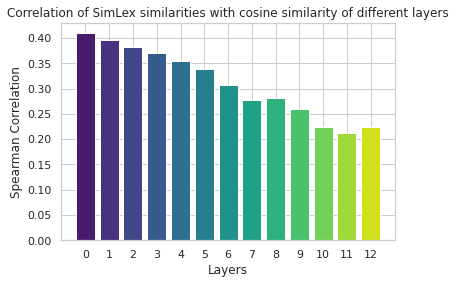

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

correlations = []

# Collect the correlations for each layer
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    correlations.append(correlation)

# Create a figure and axis
fig, ax = plt.subplots()

# Set colors for the layers
colors = sns.color_palette("viridis", len(correlations))

# Bar plot for the layers
ax.bar(range(len(correlations)), correlations, color=colors)

# Set the title and labels
ax.set_title('Correlation of SimLex similarities with cosine similarity of different layers')
ax.set_xlabel('Layers')
ax.set_ylabel('Spearman Correlation')

# Set the xticks to be the layer numbers
ax.set_xticks(range(len(correlations)))
ax.set_xticklabels(range(len(correlations)))

# Show the plot
plt.show()


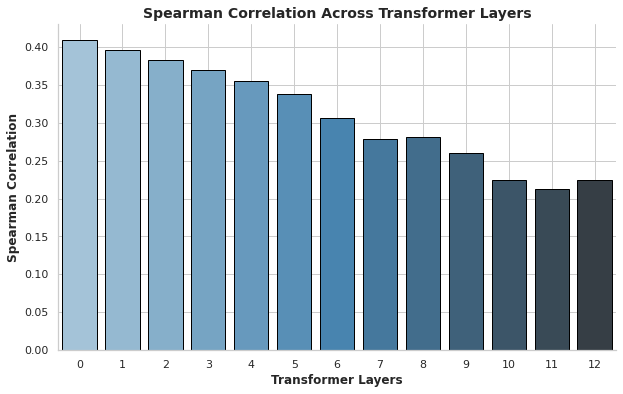

In [63]:
# Plotting in blue template
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=list(range(13)), y=correlations, palette="Blues_d", ax=ax, edgecolor='black')
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')
ax.grid(True)
sns.despine()
plt.show()

In [64]:
pos_categories = ["A", "N", "V"]
for pos in pos_categories:
    pos_data = simlex[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity_layer_0'], method='spearman')
    print(f"Spearman correlation for {pos}: {spearman_corr}")


Spearman correlation for A: 0.47393315022332977
Spearman correlation for N: 0.4491305100966188
Spearman correlation for V: 0.21303527953443935


In [65]:
# Specify the layers you want to combine
layer_nums = [0, 3]

similarity_scores = []
for _, row in simlex.iterrows():
    word1 = row['word1']
    word2 = row['word2']
    similarity = calculate_similarity(word1, word2, layer_nums)
    similarity_scores.append(similarity)

simlex['predicted_similarity'] = similarity_scores

# Assuming 'SimLex999' column contains the true similarity scores
correlation, _ = spearmanr(simlex['SimLex999'], simlex['predicted_similarity'])
print(f'Layers {layer_nums} - Spearman correlation: {correlation:.3f}')


Layers [0, 3] - Spearman correlation: 0.421


#### Code to get predicted similarity (including subtokenized words) for a specific combination of layers:

In [66]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

# Specify the layers you want to combine
layer_nums = [0, 3]

similarity_scores = []
for _, row in simlex.iterrows():
    word1 = row['word1']
    word2 = row['word2']
    similarity = calculate_similarity(word1, word2, layer_nums)
    similarity_scores.append(similarity)

simlex['predicted_similarity'] = similarity_scores

# Assuming 'SimLex999' column contains the true similarity scores
correlation, _ = spearmanr(simlex['SimLex999'], simlex['predicted_similarity'])
print(f'Layers {layer_nums} - Spearman correlation: {correlation:.3f}')


Layers [0, 3] - Spearman correlation: 0.421


#### Error analysis, for the layer combination specified in previous cell:

In [67]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object that will scale values to range from 0 to 10
scaler = MinMaxScaler(feature_range=(0, 10))

# Fit the scaler on the predicted similarity scores and transform them
simlex['predicted_similarity_scaled'] = scaler.fit_transform(simlex[['predicted_similarity']])


In [68]:
# Compute absolute differences between predicted and actual scores
simlex['abs_diff'] = abs(simlex['SimLex999'] - simlex['predicted_similarity_scaled'])

# Sort by absolute differences
simlex_sorted = simlex.sort_values('abs_diff', ascending=False)

# Print out the word pairs with the largest differences
print(simlex_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity', 'predicted_similarity_scaled', 'abs_diff']].head(10))


# Print out the word pairs with the smallest differences
print(simlex_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity', 'predicted_similarity_scaled', 'abs_diff']].tail(10))


             word1        word2  SimLex999  predicted_similarity  \
819    rondzwerven       dwalen       7.83              0.246708   
289    competentie     vermogen       7.73              0.271145   
129           film      filmrol       3.92              0.797868   
40   zelfverzekerd        zeker       7.49              0.295331   
97       elastisch     flexibel       7.32              0.289047   
321       badkamer   slaapkamer       2.03              0.660449   
12       makkelijk     moeilijk       2.17              0.656358   
115           zuid        noord       2.93              0.705121   
119      onderkant    bovenkant       3.50              0.739746   
14        moeilijk  gemakkelijk       1.92              0.633699   

     predicted_similarity_scaled  abs_diff  
819                     1.238123  6.591877  
289                     1.602813  6.127187  
129                     9.463521  5.543521  
40                      1.963764  5.526236  
97                      1.

#### POS-based analysis below:

In [69]:
# Group by POS and compute mean difference for each group
grouped = simlex.groupby('POS')['abs_diff'].mean()

# Print out the mean difference for each POS
print(grouped)

POS
A    1.893176
N    1.487026
V    1.596417
Name: abs_diff, dtype: float64


In [70]:
# Select the adjective pairs with the largest differences
adjectives = simlex[simlex['POS'] == 'A']
adjectives_sorted = adjectives.sort_values('abs_diff', ascending=False)
print('Adjective pairs with largest differences:')
print(adjectives_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))

# Select the noun pairs with the largest differences
nouns = simlex[simlex['POS'] == 'N']
nouns_sorted = nouns.sort_values('abs_diff', ascending=False)
print('\nNoun pairs with largest differences:')
print(nouns_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))

# Select the verb pairs with the largest differences
verbs = simlex[simlex['POS'] == 'V']
verbs_sorted = verbs.sort_values('abs_diff', ascending=False)
print('\nVerb pairs with largest differences:')
print(verbs_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))


Adjective pairs with largest differences:
            word1        word2  SimLex999  predicted_similarity
40  zelfverzekerd        zeker       7.49              0.295331
97      elastisch     flexibel       7.32              0.289047
12      makkelijk     moeilijk       2.17              0.656358
14       moeilijk  gemakkelijk       1.92              0.633699
79       geweldig    vreselijk       2.00              0.598138
35         slecht     immoreel       6.44              0.297153
95        beladen        zwaar       7.33              0.379018
7            kort         lang       1.78              0.540874
52   noodzakelijk   belangrijk       8.22              0.457968
63           hard        wreed       7.02              0.384657

Noun pairs with largest differences:
           word1          word2  SimLex999  predicted_similarity
289  competentie       vermogen       7.73              0.271145
129         film        filmrol       3.92              0.797868
321     badkamer     

In [71]:
pos_categories = ["A", "N", "V"]
for pos in pos_categories:
    pos_data = simlex[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity'], method='spearman')
    print(f"Spearman correlation for {pos}: {spearman_corr}")


Spearman correlation for A: 0.4724325842203637
Spearman correlation for N: 0.4590841636247042
Spearman correlation for V: 0.2472736456238106


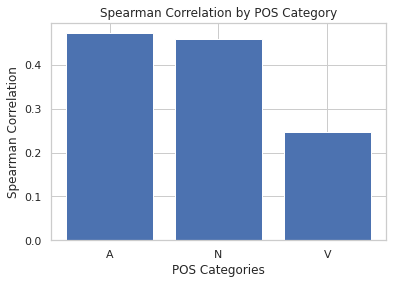

In [72]:
import matplotlib.pyplot as plt

pos_categories = ["A", "N", "V"]
spearman_corrs = []

for pos in pos_categories:
    pos_data = simlex[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity'], method='spearman')
    spearman_corrs.append(spearman_corr)

plt.bar(pos_categories, spearman_corrs)
plt.xlabel('POS Categories')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by POS Category')
plt.show()


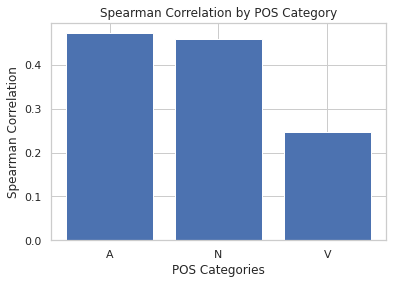

In [73]:
import matplotlib.pyplot as plt

pos_categories = ["A", "N", "V"]
spearman_corrs = []

for pos in pos_categories:
    pos_data = simlex[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity'], method='spearman')
    spearman_corrs.append(spearman_corr)

plt.bar(pos_categories, spearman_corrs)
plt.xlabel('POS Categories')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by POS Category')
plt.show()


In [74]:
simlex['abs_diff'] = abs(simlex['SimLex999'] - simlex['predicted_similarity'])
largest_diff = simlex.nlargest(10, 'abs_diff')
print(largest_diff)


         word1        word2  SimLex999 POS  predicted_similarity_layer_0  \
370       arts       dokter       9.28   N                      0.575188   
87     angstig         bang       9.06   A                      0.471193   
28   eenvoudig  gemakkelijk       9.04   A                      0.558299   
840  deelnemen      meedoen       8.90   V                      0.446401   
155   boosheid        woede       8.87   N                      0.441134   
788    creëren        maken       8.76   V                      0.369117   
22        vlug         snel       8.95   A                      0.647372   
62    cruciaal   belangrijk       8.59   A                      0.379983   
335     koppel         paar       8.56   N                      0.383221   
236    bedrijf  onderneming       8.72   N                      0.569822   

     predicted_similarity_layer_1  predicted_similarity_layer_2  \
370                      0.633879                      0.682262   
87                       0.56

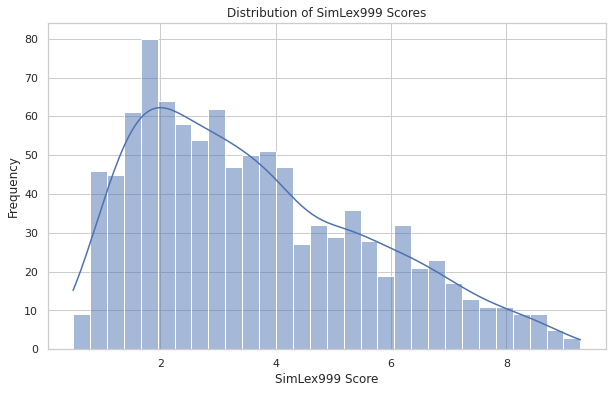

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram for SimLex999 scores
plt.figure(figsize=(10,6))
sns.histplot(data=simlex, x="SimLex999", bins=30, kde=True)
plt.title("Distribution of SimLex999 Scores")
plt.xlabel("SimLex999 Score")
plt.ylabel("Frequency")
plt.show()


#### Frequency category analysis using SUBTLEX-NL frequencies

In [76]:
# Lees de SUBTLEX-NL gegevens
subtlex_nl = pd.read_csv('SUBTLEX-NL-New.txt', sep='\t')

# Maak een woordenboek dat de frequentie van elk woord opslaat
word_frequencies = subtlex_nl.set_index('Word')['FREQcount'].to_dict()

# Nu kun je de frequenties uit dit woordenboek gebruiken in plaats van de willekeurige frequenties


In [77]:
# Add frequency data to SimLex999 DataFrame
simlex['frequency1'] = simlex['word1'].map(word_frequencies)
simlex['frequency2'] = simlex['word2'].map(word_frequencies)

# Calculate median frequency
median_freq = simlex[['frequency1', 'frequency2']].median().mean()

# Split into high frequency and low frequency subsets
simlex_high_freq = simlex[(simlex['frequency1'] > median_freq) & (simlex['frequency2'] > median_freq)]
simlex_low_freq = simlex[(simlex['frequency1'] <= median_freq) & (simlex['frequency2'] <= median_freq)]

# Specify the layers you want to combine
layer_nums = [0, 3]

for simlex_subset, freq in zip([simlex_high_freq, simlex_low_freq], ['high', 'low']):
    similarity_scores = []
    for _, row in simlex_subset.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_nums)
        similarity_scores.append(similarity)

    simlex_subset['predicted_similarity'] = similarity_scores

    # Assuming 'SimLex999' column contains the true similarity scores
    correlation, _ = spearmanr(simlex_subset['SimLex999'], simlex_subset['predicted_similarity'])
    print(f'Layers {layer_nums} - Spearman correlation for {freq} frequency words: {correlation:.3f}')


/tmp/ipykernel_999646/2544410406.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_subset['predicted_similarity'] = similarity_scores


Layers [0, 3] - Spearman correlation for high frequency words: 0.428
Layers [0, 3] - Spearman correlation for low frequency words: 0.454


In [78]:
simlex_high_freq = simlex[(simlex['frequency1'] > median_freq) & (simlex['frequency2'] > median_freq)].copy()
simlex_low_freq = simlex[(simlex['frequency1'] <= median_freq) & (simlex['frequency2'] <= median_freq)].copy()


In [79]:
# Calculate the Spearman correlation for each layer and each frequency group
spearman_results_high = []
spearman_results_low = []

for layer_num in range(13):  # For BERT base models, there are 13 layers including the output layer
    similarity_scores_high = []
    similarity_scores_low = []

    for _, row in simlex_high_freq.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, [layer_num])
        similarity_scores_high.append(similarity)

    for _, row in simlex_low_freq.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, [layer_num])
        similarity_scores_low.append(similarity)
    

    simlex_high_freq['predicted_similarity'] = similarity_scores_high
    simlex_low_freq['predicted_similarity'] = similarity_scores_low

    correlation_high, _ = spearmanr(simlex_high_freq['SimLex999'], simlex_high_freq['predicted_similarity'])
    correlation_low, _ = spearmanr(simlex_low_freq['SimLex999'], simlex_low_freq['predicted_similarity'])
    

    spearman_results_high.append(correlation_high)
    spearman_results_low.append(correlation_low)
    
    print(f'Layer {layer_num} - Spearman correlation for high frequency words: {correlation_high:.3f}')
    print(f'Layer {layer_num} - Spearman correlation for low frequency words: {correlation_low:.3f}')


Layer 0 - Spearman correlation for high frequency words: 0.444
Layer 0 - Spearman correlation for low frequency words: 0.420
Layer 1 - Spearman correlation for high frequency words: 0.401
Layer 1 - Spearman correlation for low frequency words: 0.446
Layer 2 - Spearman correlation for high frequency words: 0.388
Layer 2 - Spearman correlation for low frequency words: 0.435
Layer 3 - Spearman correlation for high frequency words: 0.356
Layer 3 - Spearman correlation for low frequency words: 0.430
Layer 4 - Spearman correlation for high frequency words: 0.345
Layer 4 - Spearman correlation for low frequency words: 0.417
Layer 5 - Spearman correlation for high frequency words: 0.331
Layer 5 - Spearman correlation for low frequency words: 0.402
Layer 6 - Spearman correlation for high frequency words: 0.327
Layer 6 - Spearman correlation for low frequency words: 0.362
Layer 7 - Spearman correlation for high frequency words: 0.337
Layer 7 - Spearman correlation for low frequency words: 0.315


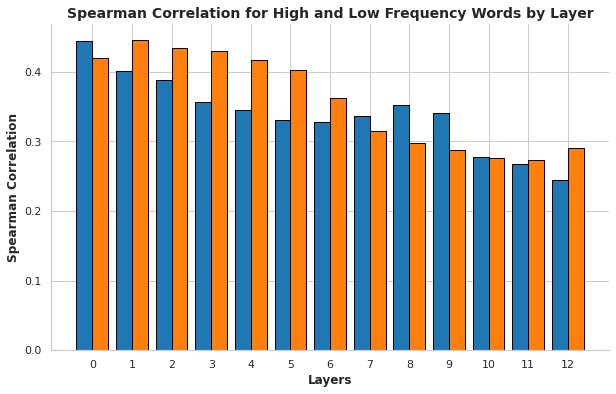

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

x = np.arange(13)  # Positions for the bars
width = 0.4        # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot side-by-side bars
ax.bar(x - width/2, spearman_results_high, width, color="#1f77b4", edgecolor='black')
ax.bar(x + width/2, spearman_results_low, width, color="#ff7f0e", edgecolor='black')


# Adding title and labels
ax.set_title('Spearman Correlation for High and Low Frequency Words by Layer', fontsize=14, fontweight='bold')
ax.set_xlabel('Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Set the xticks to be the layer numbers
ax.set_xticks(range(13))
ax.set_xticklabels(range(13))

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


#### Checking model vocabulary

In [81]:
# Get the vocabulary used by the tokenizer
vocab = tokenizer.get_vocab()

# Create an empty set to store out-of-vocabulary (OOV) words
oov_words = set()

# Check each unique word in the SimLex-999 dataset
for word in pd.concat([simlex['word1'], simlex['word2']]).unique():
    if word not in vocab:
        oov_words.add(word)

print(f'There are {len(oov_words)} out-of-vocabulary words.')
print('Some examples are:', list(oov_words)[:10])

# Remove rows in simlex where either 'word1' or 'word2' is an OOV word
simlex_no_oov = simlex[~simlex['word1'].isin(oov_words) & ~simlex['word2'].isin(oov_words)]
print(f'There are {len(simlex_no_oov)} word pairs without OOV words.')


There are 139 out-of-vocabulary words.
Some examples are: ['bedelen', 'jachthond', 'onderontwikkeld', 'elastisch', 'molecuul', 'zout', 'grootmoedig', 'bekendmaken', 'boosheid', 'vrijgevig']
There are 805 word pairs without OOV words.


### Code for getting layer-wise similarity, all layers, without subtokenized words:

In [82]:
def get_word_embedding(word, layer_nums):
    # Tokenize the word into subtokens and add special tokens [CLS] and [SEP]
    subtokens = [tokenizer.cls_token] + tokenizer.tokenize(word) + [tokenizer.sep_token]
    # Convert subtokens to input IDs
    input_ids = tokenizer.convert_tokens_to_ids(subtokens)
    # Wrap it in a tensor and add an extra batch dimension
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    # Make sure the model does not compute gradients
    with torch.no_grad():
        # Get the model outputs
        outputs = model(input_ids, output_hidden_states=True)
    # Check if layer_nums is a list or a single integer
    if isinstance(layer_nums, int):
        layer_nums = [layer_nums]
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Ignore the first and the last token ([CLS] and [SEP])
    averaged_embedding = averaged_embedding[0, 1:-1]
    # Get the mean of the subtoken vectors to get the word vector
    word_embedding = torch.mean(averaged_embedding, dim=0)
    # Convert tensor to a numpy array
    word_embedding = word_embedding.numpy()
    return word_embedding

def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [1, 12]

# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    similarity_scores = []  # Initialize similarity_scores in each iteration

    for _, row in simlex_no_oov.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

    correlation, _ = spearmanr(simlex_no_oov['SimLex999'], simlex_no_oov[f'predicted_similarity_layer_{layer_num}'])
    print(f'Layer {layer_num} - Spearman correlation (No OOV): {correlation:.3f}')


/tmp/ipykernel_999646/615702486.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores


Layer 0 - Spearman correlation (No OOV): 0.485
Layer 1 - Spearman correlation (No OOV): 0.455
Layer 2 - Spearman correlation (No OOV): 0.426
Layer 3 - Spearman correlation (No OOV): 0.405
Layer 4 - Spearman correlation (No OOV): 0.394
Layer 5 - Spearman correlation (No OOV): 0.377
Layer 6 - Spearman correlation (No OOV): 0.356
Layer 7 - Spearman correlation (No OOV): 0.325
Layer 8 - Spearman correlation (No OOV): 0.334
Layer 9 - Spearman correlation (No OOV): 0.316
Layer 10 - Spearman correlation (No OOV): 0.293
Layer 11 - Spearman correlation (No OOV): 0.288
Layer 12 - Spearman correlation (No OOV): 0.288


#### Code to get predicted similarity (including subtokenized words) for a specific combination of layers:

In [83]:
# Specify the layers you want to combine
layer_nums = [0, 3]

similarity_scores = []
for _, row in simlex_no_oov.iterrows():
    word1 = row['word1']
    word2 = row['word2']
    similarity = calculate_similarity(word1, word2, layer_nums)
    similarity_scores.append(similarity)

simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

# Assuming 'SimLex999' column contains the true similarity scores
correlation, _ = spearmanr(simlex_no_oov['SimLex999'], simlex_no_oov[f'predicted_similarity_layer_{layer_num}'])
print(f'Layers {layer_nums} - Spearman correlation (No OOV): {correlation:.3f}')

Layers [0, 3] - Spearman correlation (No OOV): 0.474


/tmp/ipykernel_999646/749547578.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores


#### Additional unused figures

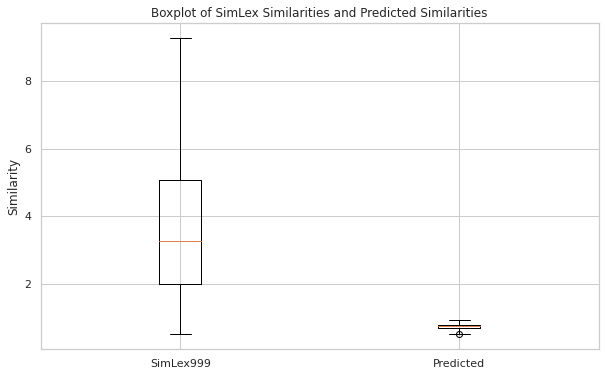

In [84]:
plt.figure(figsize=(10,6))
plt.boxplot([simlex['SimLex999'], simlex['predicted_similarity_layer_12']], labels=['SimLex999', 'Predicted'])
plt.title('Boxplot of SimLex Similarities and Predicted Similarities')
plt.ylabel('Similarity')
plt.show()


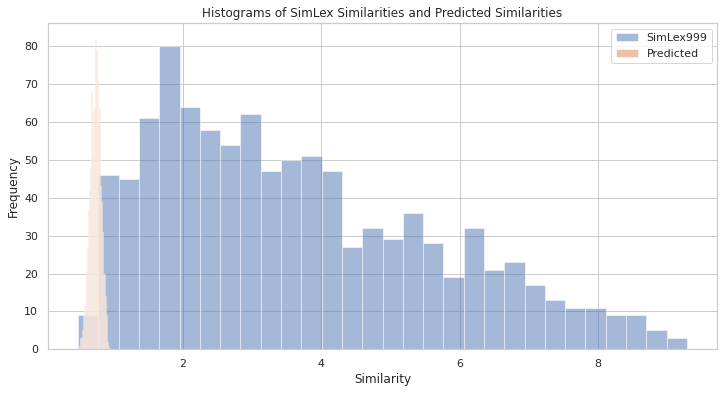

In [85]:
plt.figure(figsize=(12,6))
plt.hist(simlex['SimLex999'], bins=30, alpha=0.5, label='SimLex999')
plt.hist(simlex['predicted_similarity_layer_12'], bins=30, alpha=0.5, label='Predicted')
plt.title('Histograms of SimLex Similarities and Predicted Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


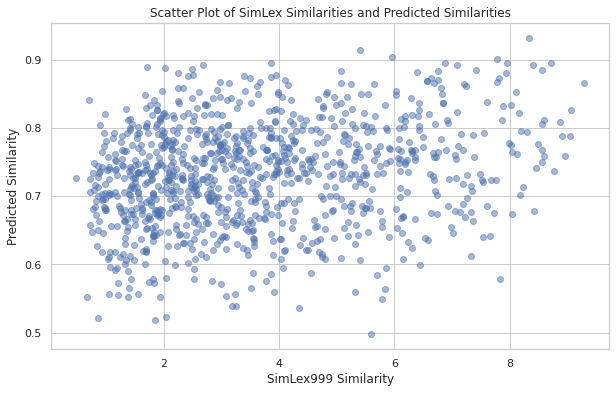

In [86]:
plt.figure(figsize=(10,6))
plt.scatter(simlex['SimLex999'], simlex['predicted_similarity_layer_12'], alpha=0.5)
plt.title('Scatter Plot of SimLex Similarities and Predicted Similarities')
plt.xlabel('SimLex999 Similarity')
plt.ylabel('Predicted Similarity')
plt.show()


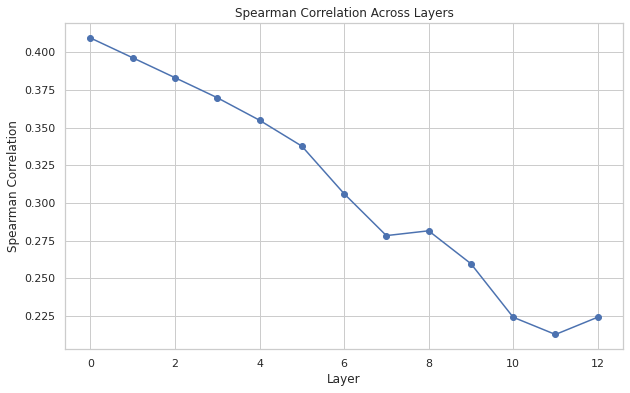

In [87]:
plt.figure(figsize=(10,6))
plt.plot(correlations, marker='o')
plt.title('Spearman Correlation Across Layers')
plt.xlabel('Layer')
plt.ylabel('Spearman Correlation')
plt.show()


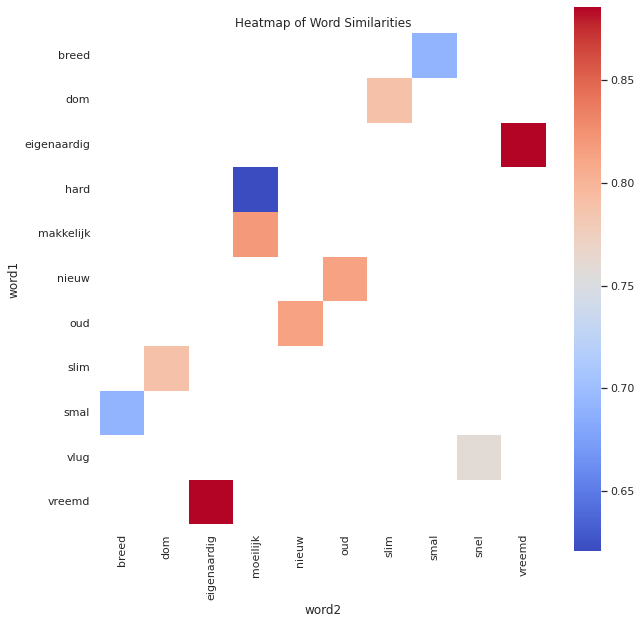

In [88]:
# Select a subset of words
subset_words = simlex['word1'].unique()[:20]  # adjust this to your needs

# Filter the dataframe to include only the subset of words
subset_simlex = simlex[(simlex['word1'].isin(subset_words)) & (simlex['word2'].isin(subset_words))]

# Pivot the filtered dataframe to create a similarity matrix
similarity_matrix = subset_simlex.pivot(index='word1', columns='word2', values='predicted_similarity_layer_12')

# Plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(similarity_matrix, cmap='coolwarm', square=True)
plt.title('Heatmap of Word Similarities')
plt.show()


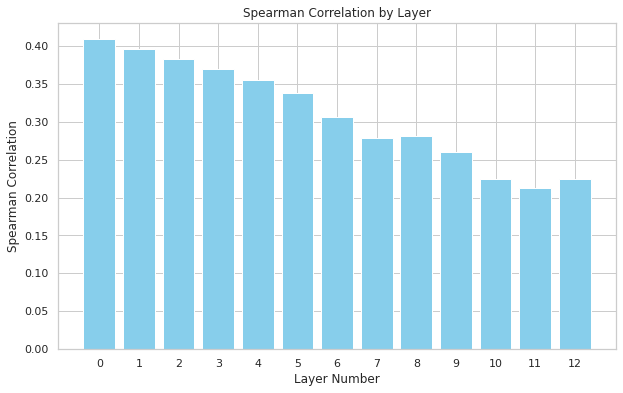

In [89]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
plt.bar(range(13), spearman_results, color='skyblue')

plt.xlabel('Layer Number')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation by Layer')
plt.xticks(range(13))

plt.show()


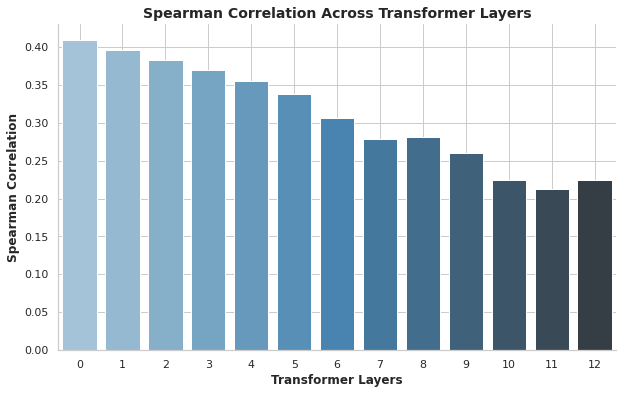

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="Blues_d", ax=ax)

# Adding title and labels
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


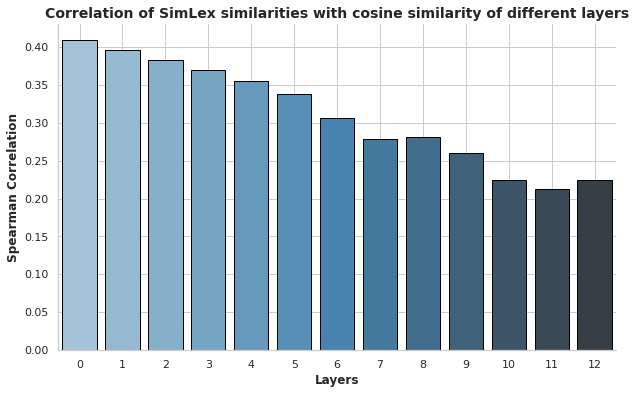

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data with edgecolor
ax = sns.barplot(x=list(range(13)), y=correlations, palette="Blues_d", ax=ax, edgecolor='black')

# Adding title and labels
ax.set_title('Correlation of SimLex similarities with cosine similarity of different layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


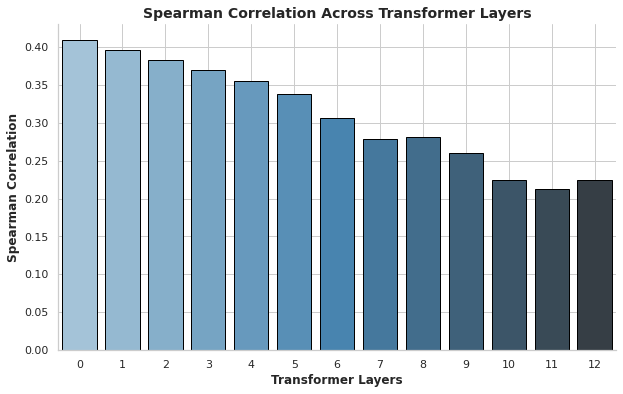

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data with edgecolor
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="Blues_d", ax=ax, edgecolor='black')

# Adding title and labels
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


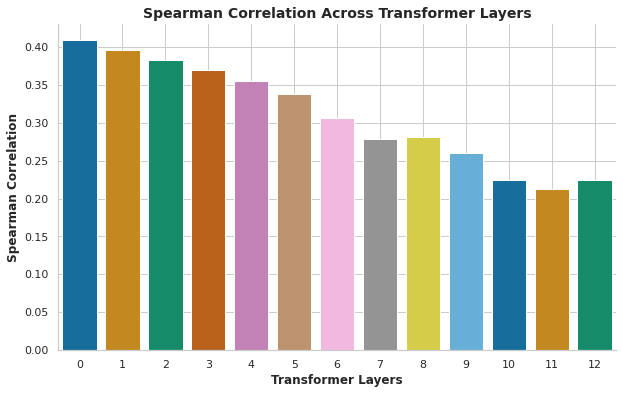

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="colorblind", ax=ax)

# Adding title and labels
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


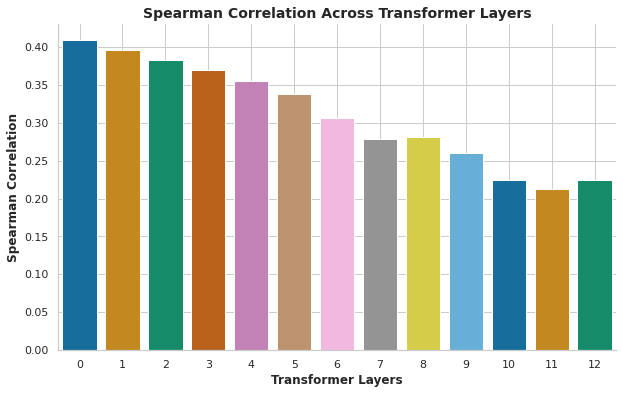

In [94]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=list(range(13)), y=spearman_results, palette="colorblind", ax=ax)
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')
ax.grid(True)
sns.despine()
plt.show()

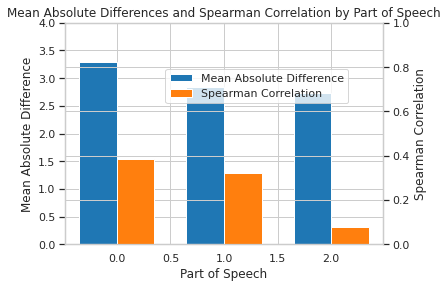

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'grouped' and 'spearman_corr' are your data
grouped = {'A': 3.297623, 'N': 2.835776, 'V': 2.725618}
spearman_corr = {'A': 0.38389480242547624, 'N': 0.3195469653921415, 'V': 0.0793393737137762}

# Prepare data for the plot
labels = grouped.keys()
mean_diffs = grouped.values()
correlations = spearman_corr.values()

# Prepare the plot
x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots()

# Create the bars for mean differences
rects1 = ax1.bar(x - width/2, mean_diffs, width, label='Mean Absolute Difference', color='tab:blue')
ax1.set_ylabel('Mean Absolute Difference')
ax1.set_xlabel('Part of Speech')
ax1.set_ylim([0, 4])  # Set the y-axis limits

# Create a second y-axis for the correlations
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, correlations, width, label='Spearman Correlation', color='tab:orange')
ax2.set_ylabel('Spearman Correlation')
ax2.set_ylim([0, 1])  # Set the y-axis limits

# Create the legend and title
fig.tight_layout()
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.8, 0.8))
plt.title('Mean Absolute Differences and Spearman Correlation by Part of Speech')


# Show the plot
plt.show()


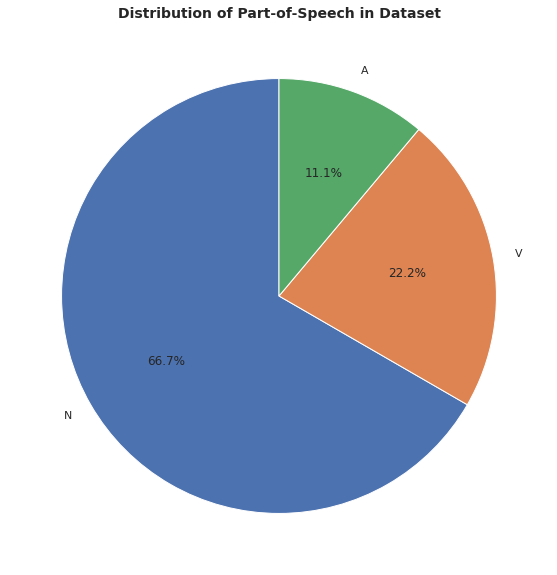

In [99]:
import matplotlib.pyplot as plt

# Calculate POS frequencies
pos_counts = simlex['POS'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10,10))
plt.pie(pos_counts, labels=pos_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Part-of-Speech in Dataset', fontsize=14, fontweight='bold')
plt.show()


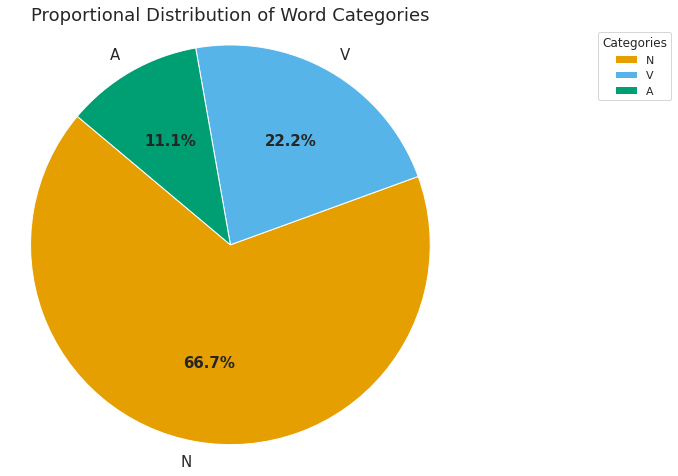

In [103]:
import matplotlib.pyplot as plt

# Data to plot
labels = pos_counts.index
sizes = pos_counts

# Colors - choosing a colorblind-friendly palette
colors = ['#E69F00','#56B4E9','#009E73']

# Plot
fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Adding a title and improving the labels
plt.title('Proportional Distribution of Word Categories', fontsize=18)
ax.legend(wedges, labels, title='Categories', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1))

# Changing the fontsize of the labels and percentages
plt.setp(autotexts, size=15, weight='bold')
plt.setp(texts, size=15)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()


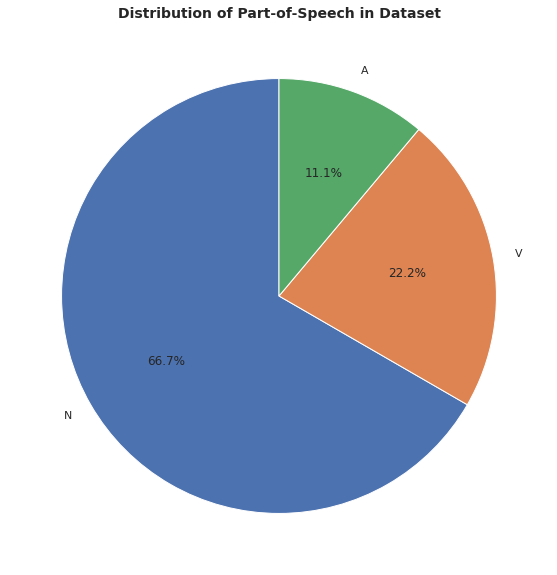

In [104]:
import matplotlib.pyplot as plt

# Calculate POS frequencies
pos_counts = simlex['POS'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10,10))
plt.pie(pos_counts, labels=pos_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Part-of-Speech in Dataset', fontsize=14, fontweight='bold')
plt.show()
